In [1]:
# Import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from config import PGHOST, PGDATABASE, PGUSER, PGPASSWORD

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM

In [2]:
# Define a function to connect to AWS database instance

def connect():
    
    # Set up a connection to the postgres server.
    conn_string = "host="+PGHOST +" port="+ "5432" +" dbname="+PGDATABASE +" user=" + PGUSER \
                  +" password="+ PGPASSWORD
    
    conn = psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
    
    return conn, cursor

In [3]:
conn, cursor = connect()

Connected!


In [4]:
# Get the data, read SQL query into data frame
bb_data = pd.read_sql_query("SELECT * FROM blackberry", con=conn)
bb_df = pd.DataFrame(bb_data)
bb_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,1999-02-04,2.145833,2.166667,1.895833,1.924479,1.924479,16788600
1,1999-02-05,1.929688,1.947917,1.822917,1.833333,1.833333,3053400
2,1999-02-08,1.854167,1.927083,1.783854,1.812500,1.812500,1548000
3,1999-02-09,1.822917,1.833333,1.656250,1.666667,1.666667,3501600
4,1999-02-10,1.708333,1.708333,1.604167,1.677083,1.677083,1597200


In [5]:
# Get the data, read SQL query into data frame
gg_data = pd.read_sql_query("SELECT * FROM google", con=conn)
gg_df = pd.DataFrame(gg_data)
gg_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,2.652653,183772044


In [6]:
# Get the data, read SQL query into data frame
nf_data = pd.read_sql_query("SELECT * FROM netflix", con=conn)
nf_df = pd.DataFrame(nf_data)
nf_df.head()

,Date,open_price,high_price,low_price,close_price,adj_close,volume
0,2002-05-23,1.156429,1.242857,1.145714,1.196429,1.196429,104790000
1,2002-05-24,1.214286,1.225000,1.197143,1.210000,1.210000,11104800
2,2002-05-28,1.213571,1.232143,1.157143,1.157143,1.157143,6609400
3,2002-05-29,1.164286,1.164286,1.085714,1.103571,1.103571,6757800
4,2002-05-30,1.107857,1.107857,1.071429,1.071429,1.071429,10154200


In [7]:
# Check the rows and columns of dfs
print(bb_df.shape)
print(gg_df.shape)
print(nf_df.shape)

(5945, 7)
(4553, 7)
(5117, 7)


In [8]:
# Check if there is null values
bb_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [9]:
# Check the data types in df
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         5945 non-null   object 
 1   open_price   5945 non-null   float64
 2   high_price   5945 non-null   float64
 3   low_price    5945 non-null   float64
 4   close_price  5945 non-null   float64
 5   adj_close    5945 non-null   float64
 6   volume       5945 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 325.2+ KB


In [10]:
gg_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [11]:
nf_df.isnull().sum()

Date           0
open_price     0
high_price     0
low_price      0
close_price    0
adj_close      0
volume         0
dtype: int64

In [7]:
# Change [Date] data type to data time

bb_df['Date'] = pd.to_datetime(bb_df.Date)
gg_df['Date'] = pd.to_datetime(gg_df.Date)
nf_df['Date'] = pd.to_datetime(nf_df.Date)

In [8]:
bb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5945 entries, 0 to 5944
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         5945 non-null   datetime64[ns]
 1   open_price   5945 non-null   float64       
 2   high_price   5945 non-null   float64       
 3   low_price    5945 non-null   float64       
 4   close_price  5945 non-null   float64       
 5   adj_close    5945 non-null   float64       
 6   volume       5945 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 325.2 KB


In [9]:
# Delete 'Adj Close' column and check df

bb_df = bb_df.drop('adj_close', axis=1)
gg_df = gg_df.drop('adj_close', axis=1)
nf_df = nf_df.drop('adj_close', axis=1)

In [10]:
bb_df.set_index('Date')
gg_df.set_index('Date')
nf_df.set_index('Date')

,open_price,high_price,low_price,close_price,volume
Date,,,,,
2002-05-23,1.156429,1.242857,1.145714,1.196429,104790000
2002-05-24,1.214286,1.225000,1.197143,1.210000,11104800
2002-05-28,1.213571,1.232143,1.157143,1.157143,6609400
2002-05-29,1.164286,1.164286,1.085714,1.103571,6757800
2002-05-30,1.107857,1.107857,1.071429,1.071429,10154200
...,...,...,...,...,...
2022-09-13,226.500000,227.690000,217.720000,218.130000,8000100
2022-09-14,219.820000,228.000000,215.800000,224.120000,8230300
2022-09-15,230.470000,242.290000,229.100000,235.380000,19454100


In [11]:
nf_df = nf_df.loc[nf_df.Date >='2017-01-01']

nf_df.head()

,Date,open_price,high_price,low_price,close_price,volume
3679,2017-01-03,124.96,128.19,124.31,127.49,9437900
3680,2017-01-04,127.49,130.17,126.55,129.41,7843600
3681,2017-01-05,129.22,132.75,128.90,131.81,10185500
3682,2017-01-06,132.08,133.88,129.81,131.07,10657900
3683,2017-01-09,131.48,131.99,129.89,130.95,5771800


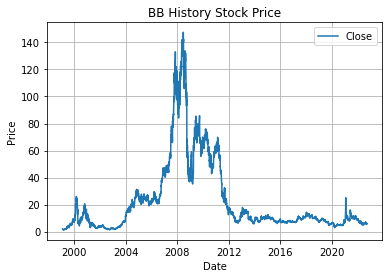

In [16]:
# Vistulize the stock price trend by using 'Close' column
plt.plot(bb_df['Date'], bb_df['close_price'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('BB History Stock Price')
plt.grid()
plt.legend()
plt.show()

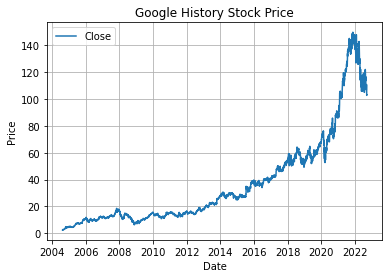

In [17]:
# Vistulize the stock price trend by using 'Close' column
plt.plot(gg_df['Date'], gg_df['close_price'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Google History Stock Price')
plt.grid()
plt.legend()
plt.show()

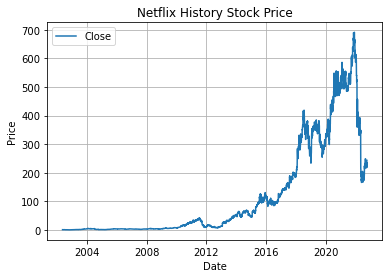

In [18]:
# Vistulize the stock price trend by using 'Close' column
plt.plot(nf_df['Date'], nf_df['close_price'], label='Close')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Netflix History Stock Price')
plt.grid()
plt.legend()
plt.show()

# Multiple Linear Regression Model

In [19]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [20]:
# Split our preprocessed data into our features and target arrays

X = bb_df[['open_price','high_price','low_price','volume']].values
y = bb_df['close_price'].values

In [21]:
# Split the preprocessed data into a training and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [22]:
# Check the shape of X_train and X_test

print(X_train.shape)
print(X_test.shape)

(4458, 4)
(1487, 4)


In [23]:
# Build linear reg model

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [29]:
# Check the model score
#lr_model.score(X_train, y_train)

In [27]:
# Make stock price prediction

prediction = lr_model.predict(X_test)

print(prediction.shape)
print(prediction)

(1487,)
[ 7.07024107  9.91884785 62.05358664 ...  2.62858694 20.86661344
 22.28151238]


In [28]:
# Check R sqr value
from sklearn.metrics import r2_score
print(r2_score(y_test, prediction))

0.9997311376744307


In [31]:
# Compare y_test and our prediction value

pred_df = pd.DataFrame({'Actual Price':y_test, 'Predicted Price':prediction})

pred_df.head()

,Actual Price,Predicted Price
0,7.05,7.070241
1,9.88,9.918848
2,62.41,62.053587
3,7.43,7.441019
4,21.63,21.906761


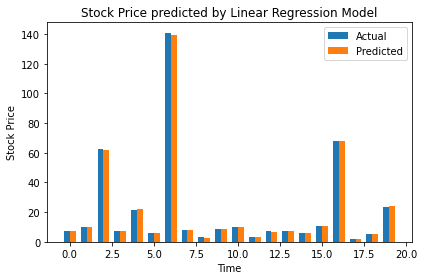

In [27]:
# Plot the actual and predicted price
# from the above data frame, we can see the difference between 'actual price' and 'predicted price' is tiny
# if using line graph, the two lines will be overlapped to each other.
# so we choose to use bar graph to show the difference of first 20 rows of data frame

fig_df = pred_df.loc[pred_df.index<20]

x = np.arange(len(fig_df['Actual Price']))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, fig_df['Actual Price'], width, label='Actual')
rects2 = ax.bar(x + width/2, fig_df['Predicted Price'], width, label='Predicted')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Time')
ax.set_ylabel('Stock Price')
ax.set_title('Stock Price predicted by Linear Regression Model')
ax.legend()
fig.tight_layout()
plt.show()

In [28]:
print(lr_model.coef_)
print(lr_model.intercept_)

[-6.04633013e-01  8.49151347e-01  7.54209287e-01 -1.14024046e-09]
-0.0010973939316194503


In [29]:
# Calculate the MSE for our model
# The mean squared error (MSE) tells you how close a regression line is to a set of points
# return a non-negative floating point value (the best value is 0.0)

from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, prediction)

0.22175367673634705